In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
from glob import *
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
data = pd.read_csv(r"C:\Users\nihuser\Downloads\dataset\train.csv")

In [2]:

# card_list , nofind = [], []
# for i in range(len(data['disease'])):
    
#     if data['disease'][i] == 'Cardiomegaly':
#         card_list.append(data['imageID'][i])
#     else:
#         nofind.append(data['imageID'][i])

In [9]:
# src_dir = r'C:\Users\nihuser\Downloads\dataset\train'
# Cardiomegaly = r'C:\Users\nihuser\Downloads\dataset\labels\Cardiomegaly'
# os.makedirs(Cardiomegaly)
# nofinding = r'C:\Users\nihuser\Downloads\dataset\labels\nofinding'
# os.makedirs(nofinding)

# for pngfile in iglob(os.path.join(src_dir, "*.png")):
#     for i in card_list:
#         if i in pngfile:
#             shutil.copy(pngfile, Cardiomegaly)
            
#     for i in nofind:
#         if i in pngfile:
#             shutil.copy(pngfile, nofinding)
        

In [11]:
image_size = (180,180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\nihuser\Downloads\dataset\labels',
    validation_split=0.2,
    subset="training",
    seed=13,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1750 files belonging to 2 classes.
Using 1400 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\nihuser\Downloads\dataset\labels',
    validation_split=0.2,
    subset="validation",
    seed=13,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1750 files belonging to 2 classes.
Using 350 files for validation.


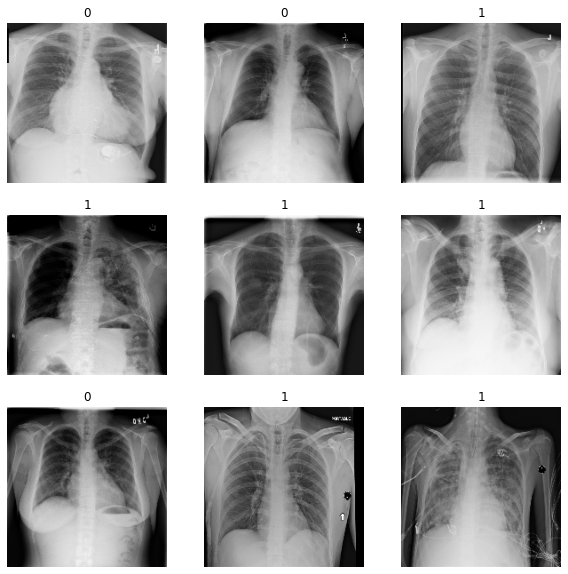

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        
    ]
)

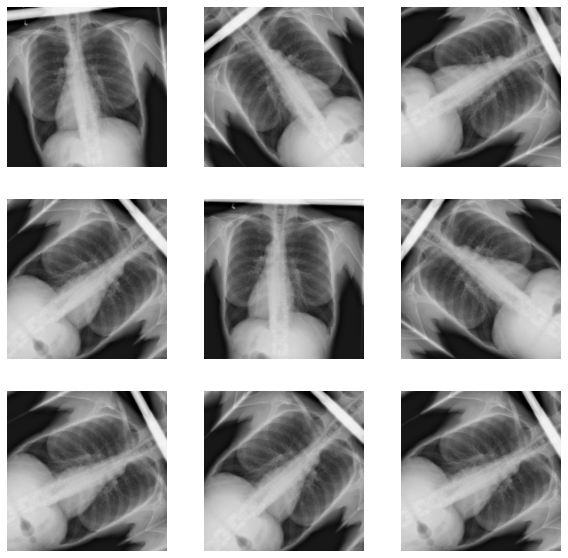

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")


In [16]:
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    #base_mobilenet_model = MobileNet(input_shape =  input_shape, 
                                # include_top = False, weights = 'imagenet')
    

#     base_vgg_model = VGG16(input_shape = (180, 180, 3), # Shape of our images
#     include_top = False, # Leave out the last fully connected layer
#     weights = 'imagenet')
    
#     for layer in base_vgg_model.layers[:-4]:
#         layer.trainable = False
    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    #x = base_vgg_model(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d_6 (Conv2D)              (None, 90, 90, 32)   896         ['rescaling_1[0][0]']      

In [18]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/60
44/44 [==============================] - 125s 3s/step - loss: 0.7574 - accuracy: 0.5443 - val_loss: 0.6972 - val_accuracy: 0.4800
Epoch 2/60
44/44 [==============================] - 123s 3s/step - loss: 0.7166 - accuracy: 0.5721 - val_loss: 0.7245 - val_accuracy: 0.4800
Epoch 3/60
44/44 [==============================] - 125s 3s/step - loss: 0.6959 - accuracy: 0.5786 - val_loss: 0.7379 - val_accuracy: 0.4800
Epoch 4/60
44/44 [==============================] - 124s 3s/step - loss: 0.6795 - accuracy: 0.5957 - val_loss: 0.7147 - val_accuracy: 0.4800
Epoch 5/60
44/44 [==============================] - 124s 3s/step - loss: 0.6988 - accuracy: 0.5814 - val_loss: 0.7061 - val_accuracy: 0.4800
Epoch 6/60
44/44 [==============================] - 123s 3s/step - loss: 0.6717 - accuracy: 0.5979 - val_loss: 0.6949 - val_accuracy: 0.5086
Epoch 7/60
44/44 [==============================] - 123s 3s/step - loss: 0.6575 - accuracy: 0.6243 - val_loss: 0.6899 - val_accuracy: 0.5229
Epoch 8/60
44

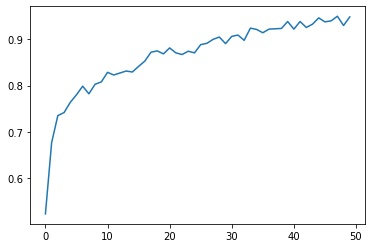

In [32]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'])
pyplot.show()

In [33]:
test_data = pd.read_csv(r"C:\Users\nihuser\Downloads\dataset\test.csv")

In [34]:
test_data.head()

,imageID,disease
0,00000001_000.png,NaN
1,00000013_045.png,NaN
2,00000032_000.png,NaN
3,00000032_053.png,NaN
4,00000039_002.png,NaN


In [35]:
disease_lst = []
for i in test_data['imageID']:
    path = r'C:\Users\nihuser\Downloads\dataset\test\{}'.format(i)
    img = keras.preprocessing.image.load_img(
    path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]
    print(score)
    if (100 * (1 - score))>(100 * score):
        disease_lst.append('Cardiomegaly')
    else:
        disease_lst.append('No Finding')
    print(
        "This image is %.2f percent cardiomegaly and %.2f percent no finding."
        % (100 * (1 - score), 100 * score)
    )
    
    

[0.00029302]
This image is 99.97 percent cardiomegaly and 0.03 percent no finding.
[0.08118093]
This image is 91.88 percent cardiomegaly and 8.12 percent no finding.
[0.04988989]
This image is 95.01 percent cardiomegaly and 4.99 percent no finding.
[0.0055221]
This image is 99.45 percent cardiomegaly and 0.55 percent no finding.
[0.4327386]
This image is 56.73 percent cardiomegaly and 43.27 percent no finding.
[0.02348068]
This image is 97.65 percent cardiomegaly and 2.35 percent no finding.
[0.933158]
This image is 6.68 percent cardiomegaly and 93.32 percent no finding.
[0.04868066]
This image is 95.13 percent cardiomegaly and 4.87 percent no finding.
[0.00018293]
This image is 99.98 percent cardiomegaly and 0.02 percent no finding.
[0.9978262]
This image is 0.22 percent cardiomegaly and 99.78 percent no finding.
[0.00023863]
This image is 99.98 percent cardiomegaly and 0.02 percent no finding.
[0.9810093]
This image is 1.90 percent cardiomegaly and 98.10 percent no finding.
[0.999992

[0.8965181]
This image is 10.35 percent cardiomegaly and 89.65 percent no finding.
[0.9999948]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.00076932]
This image is 99.92 percent cardiomegaly and 0.08 percent no finding.
[0.00597325]
This image is 99.40 percent cardiomegaly and 0.60 percent no finding.
[0.00098747]
This image is 99.90 percent cardiomegaly and 0.10 percent no finding.
[0.10190615]
This image is 89.81 percent cardiomegaly and 10.19 percent no finding.
[0.996672]
This image is 0.33 percent cardiomegaly and 99.67 percent no finding.
[0.67690927]
This image is 32.31 percent cardiomegaly and 67.69 percent no finding.
[0.03074196]
This image is 96.93 percent cardiomegaly and 3.07 percent no finding.
[0.9890832]
This image is 1.09 percent cardiomegaly and 98.91 percent no finding.
[0.80318135]
This image is 19.68 percent cardiomegaly and 80.32 percent no finding.
[0.7200156]
This image is 28.00 percent cardiomegaly and 72.00 percent no finding.
[0.0

[0.00031736]
This image is 99.97 percent cardiomegaly and 0.03 percent no finding.
[0.99996656]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.9999642]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.99315643]
This image is 0.68 percent cardiomegaly and 99.32 percent no finding.
[0.85611546]
This image is 14.39 percent cardiomegaly and 85.61 percent no finding.
[0.9999961]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.08110002]
This image is 91.89 percent cardiomegaly and 8.11 percent no finding.
[1.]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.02316105]
This image is 97.68 percent cardiomegaly and 2.32 percent no finding.
[0.99049854]
This image is 0.95 percent cardiomegaly and 99.05 percent no finding.
[0.01620373]
This image is 98.38 percent cardiomegaly and 1.62 percent no finding.
[0.6690593]
This image is 33.09 percent cardiomegaly and 66.91 percent no finding.
[0.328674

[0.8360013]
This image is 16.40 percent cardiomegaly and 83.60 percent no finding.
[0.00019047]
This image is 99.98 percent cardiomegaly and 0.02 percent no finding.
[0.63460094]
This image is 36.54 percent cardiomegaly and 63.46 percent no finding.
[0.9971682]
This image is 0.28 percent cardiomegaly and 99.72 percent no finding.
[0.9998338]
This image is 0.02 percent cardiomegaly and 99.98 percent no finding.
[0.99943936]
This image is 0.06 percent cardiomegaly and 99.94 percent no finding.
[0.39882636]
This image is 60.12 percent cardiomegaly and 39.88 percent no finding.
[0.00656524]
This image is 99.34 percent cardiomegaly and 0.66 percent no finding.
[0.32911247]
This image is 67.09 percent cardiomegaly and 32.91 percent no finding.
[0.99999845]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.9999998]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.9994764]
This image is 0.05 percent cardiomegaly and 99.95 percent no finding.
[0.

[0.97434723]
This image is 2.57 percent cardiomegaly and 97.43 percent no finding.
[0.9503565]
This image is 4.96 percent cardiomegaly and 95.04 percent no finding.
[0.00097561]
This image is 99.90 percent cardiomegaly and 0.10 percent no finding.
[0.972027]
This image is 2.80 percent cardiomegaly and 97.20 percent no finding.
[0.30986652]
This image is 69.01 percent cardiomegaly and 30.99 percent no finding.
[0.55917996]
This image is 44.08 percent cardiomegaly and 55.92 percent no finding.
[0.99960184]
This image is 0.04 percent cardiomegaly and 99.96 percent no finding.
[0.28391105]
This image is 71.61 percent cardiomegaly and 28.39 percent no finding.
[3.903382e-05]
This image is 100.00 percent cardiomegaly and 0.00 percent no finding.
[0.01282161]
This image is 98.72 percent cardiomegaly and 1.28 percent no finding.
[0.99999005]
This image is 0.00 percent cardiomegaly and 100.00 percent no finding.
[0.9980564]
This image is 0.19 percent cardiomegaly and 99.81 percent no finding.
[

In [36]:
test_data['disease'] = disease_lst

In [37]:
test_data.head()

,imageID,disease
0,00000001_000.png,Cardiomegaly
1,00000013_045.png,Cardiomegaly
2,00000032_000.png,Cardiomegaly
3,00000032_053.png,Cardiomegaly
4,00000039_002.png,Cardiomegaly


In [38]:
test_data.to_csv(r'C:\Users\nihuser\Downloads\dataset\submission_vgg16.csv',index=False)